# Project 1g: using real-world geographic data

In [2]:
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt
# from matplotlib import cm
import numpy as np
import pandas as pd
import os

from scipy.stats import normaltest

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# Loading the terrain data
terrain1 = imread('SRTM_data_Norway_1.tif'); trname1 = "Møsvatn"
terrain2 = imread('SRTM_data_Norway_2.tif'); trname2 = "Stavanger"
terrain3 = imread('oslo.tif'); trname3 = "Oslo"
terrain4 = imread('eide.tif'); trname4 = "Eide"
print(type(terrain1), terrain1.shape, terrain2.shape, type(terrain1[0, 0]))

<class 'numpy.ndarray'> (3601, 1801) (3601, 1801) <class 'numpy.int16'>


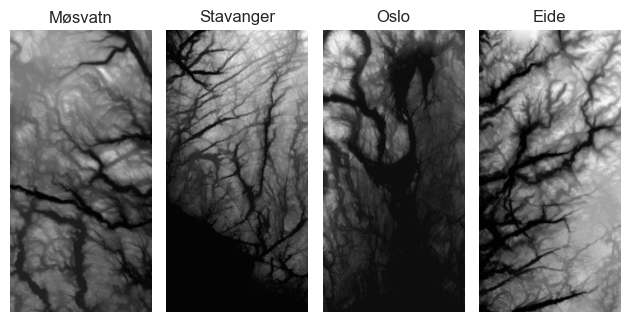

In [6]:
# Plotting the terrains
fig, ax = plt.subplots(ncols=4)
ax = ax.ravel()
for axx, tr, tr_nm in zip(ax, [terrain1, terrain2, terrain3, terrain4], [trname1, trname2, trname3, trname4]):
    axx.imshow(tr, cmap="gray")
    axx.set_title(tr_nm)
#ax[0].imshow(terrain1, cmap="gray")
#ax[1].imshow(terrain2, cmap="gray")
#ax[2].imshow(terrain3, cmap="gray")
#ax[3].imshow(terrain4, cmap="gray")
[axx.axis("off") for axx in ax]
fig.tight_layout()
fig.savefig(os.path.join("output_terrain", 'terrains.png'))
plt.show()

In [53]:
# Splitting the data from terrain1 into train / test
terrain1_values = terrain1.flatten()


data = terrain1


data_orig = data.copy()

# Downsample the data

data = resize(data, (int(data.shape[0]/12), int(data.shape[1]/12)), anti_aliasing=True)

# Perform a gaussian smoothing of the data

print(data.shape)

x = np.arange(0, data.shape[0])
y = np.arange(0, data.shape[1])

x, y = np.meshgrid(x, y)

data_flat = data.ravel()
x = x.ravel()
y = y.ravel()

index_vals = np.array(range(np.prod(data.shape)))
idx_train, idx_test = train_test_split(
        index_vals, test_size=0.3, random_state=42)


#idx_train, idx_test = train_test_split(index_vals, test_size=.20, random_state=42)
#print(idx_train.shape, idx_test.shape, round(idx_train.shape[0] / idx_test.shape[0], 2))

values_train_raw = terrain1_values[idx_train].reshape(-1, 1)
values_test_raw = terrain1_values[idx_test].reshape(-1, 1)

# Coordinate values (x and y coordinates, NOT as model variables!)
x_train = idx_train % terrain1.shape[0]
y_train = idx_train // terrain1.shape[0]
x_test = idx_test % terrain1.shape[0]
y_test = idx_test // terrain1.shape[0]

(300, 150)


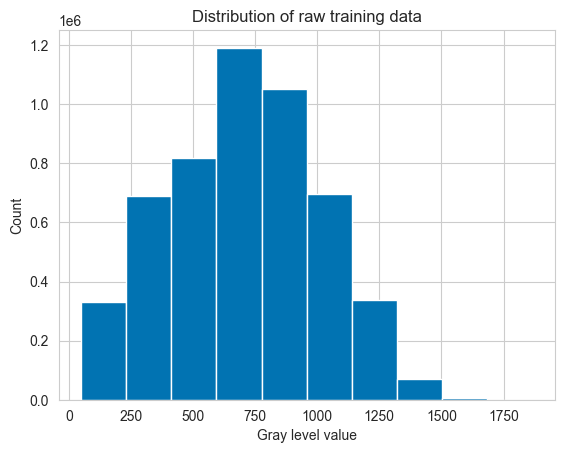

NormaltestResult(statistic=array([194304.81035592]), pvalue=array([0.]))


In [8]:
# Looking at the shape of the training data, to decide how to scale the data
# The test data should not be used for this to avoid data leakage (as the decision process is a form of learning, even though it is human and not machine!)
fig = plt.subplots()
plt.hist(values_train_raw.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of raw training data")
plt.show()

print(normaltest(values_train_raw))

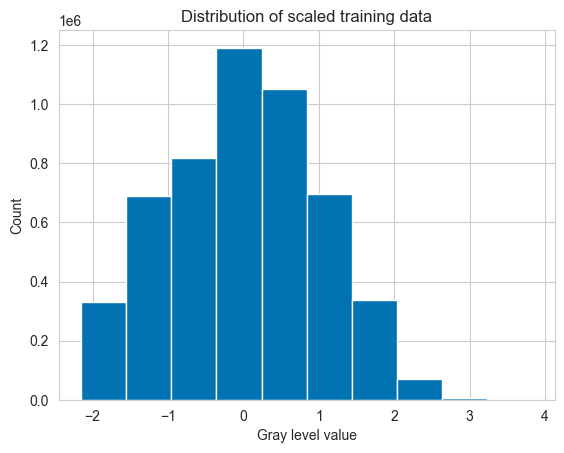

In [47]:
# The data seems to follow a normal distrubtion, therefore using standard scaling / z-score normalizing
# which centers the data to zero and scales to a standard deviation of 1
scaler_image = StandardScaler()
values_train = scaler_image.fit_transform(values_train_raw) # Only fit to training data
values_test = scaler_image.transform(values_test_raw)

fig = plt.subplots()
plt.hist(values_train.ravel())
plt.xlabel("Gray level value")
plt.ylabel("Count")
plt.title("Distribution of scaled training data")
plt.show()

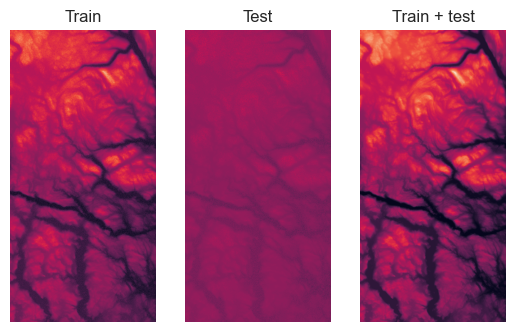

In [11]:
# Validating the train / test split visually by plotting images separately and combined
img_train = np.empty(shape=len(index_vals))
img_test = np.empty(shape=len(index_vals))

img_train[idx_train] = values_train.ravel()
img_test[idx_test] = values_test.ravel()

img_train = img_train.reshape(terrain1.shape)
img_test = img_test.reshape(terrain1.shape)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_train)
ax[0].set_title("Train")
ax[1].imshow(img_test)
ax[1].set_title("Test")
ax[2].imshow(img_train + img_test)
ax[2].set_title("Train + test")
[axi.axis("off") for axi in ax]

plt.show()

In [12]:
# Calculating and normalizing x and y - values,
# using a min-max scaler as each pair of values appear only once - i.e. are uniformly distributed
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

x_train = scaler_x.fit_transform(x_train.reshape(-1, 1)).reshape(-1)
x_test = scaler_x.transform(x_test.reshape(-1, 1)).reshape(-1)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

print(x_train.shape, y_train.shape)

(5188320,) (5188320,)


### OLS
Creating the design matrix $X$ with $x$ and $y$ as features up until degree $p$

In [9]:
# Creating design matrix X
# no intercept needed as image gray level data are centered on zero

def create_2d_polynomial_design_matrix(x, y, pmax=5, include_interactions=False):
    # Create design matrix for polynomial up to degree 5, using both x and y as predictors, as [x, y, x^2, y^2, xy, ....]
    # TODO: include interaction terms xy, x^2y, xy^2, etc...
    N = len(x)
    M = 1 + 2 * pmax
    X = np.empty(shape=(N, M))
    m = 0

    for p in range(pmax + 1):
        if p == 0:
            X[:, m] = np.ones(N)    # only need one rows for intercept
            m += 1
        else:
            X[:, m] = x**p
            X[:, m + 1] = y**p
            m += 2
    # print(f"Design matrix of polynomial up to degree {pmax} created:", X.shape)

    return X


def beta_ols_estimation(X, y):
    try:
        X_inv = np.linalg.inv(X.T.dot(X))
    except Exception as e:
        print(*e.args)
        X_inv = np.linalg.pinv(X.T.dot(X))

    betas = X_inv.dot(X.T).dot(y)
    return betas

from utils import generate_design_matrix

scores = pd.DataFrame(dtype=float)

for p in range(25):
    # Big X = design matrix
#    X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
#    X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    X_train = generate_design_matrix(x_train, y_train, n=p)
    X_test = generate_design_matrix(x_test, y_test, n=p)

    
    betas = beta_ols_estimation(X_train, values_train)
    zhat_train = X_train @ betas
    zhat_test = X_test @ betas
    
    r2_train, r2_test = r2_score(values_train, zhat_train), r2_score(values_test, zhat_test)
    mse_train, mse_test = mean_squared_error(values_train, zhat_train), mean_squared_error(values_test, zhat_test)

    print(f"p={p}\t {X_train.shape} \t r2 train / test = {r2_train:.3e} / {r2_test:.3e}\t mse = {mse_train:.3e} / {mse_test:.3e}")
    scores.loc[p, ["r2_train", "r2_test", "mse_train", "mse_test"]] = [r2_train, r2_test, mse_train, mse_test]

print(scores)

p=0	 (5188320, 1) 	 r2 train / test = 0.000e+00 / -1.220e-07	 mse = 1.000e+00 / 1.001e+00
p=1	 (5188320, 3) 	 r2 train / test = 3.448e-01 / 3.452e-01	 mse = 6.552e-01 / 6.554e-01
p=2	 (5188320, 6) 	 r2 train / test = 3.675e-01 / 3.681e-01	 mse = 6.325e-01 / 6.325e-01
p=3	 (5188320, 10) 	 r2 train / test = 3.832e-01 / 3.840e-01	 mse = 6.168e-01 / 6.166e-01
p=4	 (5188320, 15) 	 r2 train / test = 3.832e-01 / 3.840e-01	 mse = 6.168e-01 / 6.166e-01
p=5	 (5188320, 21) 	 r2 train / test = 3.832e-01 / 3.840e-01	 mse = 6.168e-01 / 6.166e-01
p=6	 (5188320, 28) 	 r2 train / test = 3.832e-01 / 3.840e-01	 mse = 6.168e-01 / 6.166e-01
p=7	 (5188320, 36) 	 r2 train / test = 3.833e-01 / 3.840e-01	 mse = 6.167e-01 / 6.165e-01
p=8	 (5188320, 45) 	 r2 train / test = 3.833e-01 / 3.841e-01	 mse = 6.167e-01 / 6.165e-01


KeyboardInterrupt: 

# Cross-Validation

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
2


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e+03, tolerance: 6.278e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e+03, tolerance: 6.313e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

3


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+03, tolerance: 6.278e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+03, tolerance: 6.313e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

4


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+03, tolerance: 6.278e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.152e+03, tolerance: 6.313e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

       MSE_train     MSE_test     R2_train      R2_test Polynomial    Lambda  \
0       1.002136     1.003067     0.000329    -0.000674          1         0   
1       1.001718     1.003533     0.000746    -0.001137          2         0   
2       1.001766     1.003116     0.000699    -0.000724          3         0   
3       1.001051     1.003451     0.001417    -0.001058          4         0   
4       1.000255     1.004212     0.002208    -0.001817          5         0   
..           ...          ...          ...          ...        ...       ...   
579  6323.147178  6324.406278 -6306.632398 -6308.303189          4  0.054556   
580  6323.211662  6324.487726 -6306.696999  -6308.38328          4  0.112884   
581  6323.145445  6324.414645 -6306.631616 -6308.312742          4  0.233572   
582   6323.07894  6324.327193 -6306.566169 -6308.228985          4  0.483293   
583  6322.986934  6324.242358 -6306.474889 -6308.146886          4       1.0   

      Type Folds  
0      OLS     5  
1

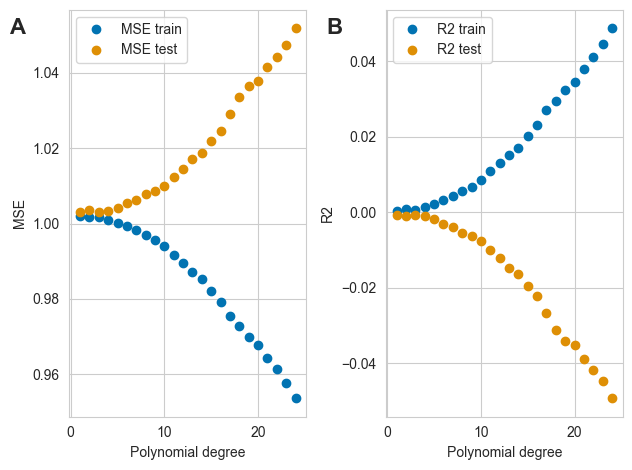

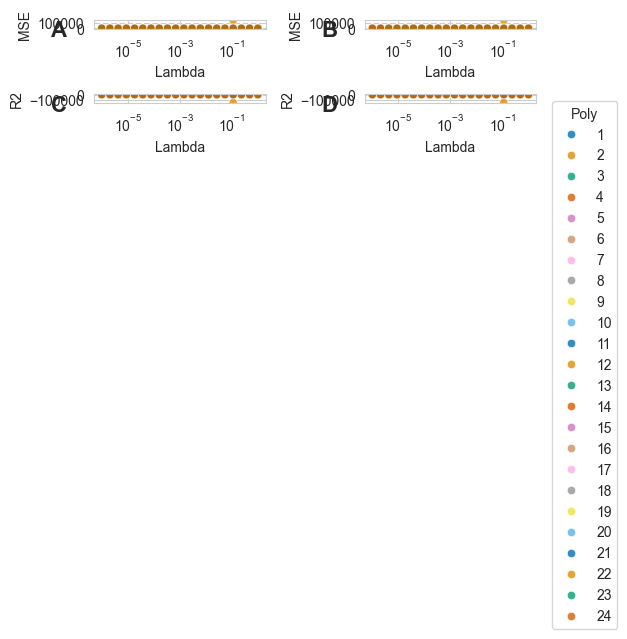

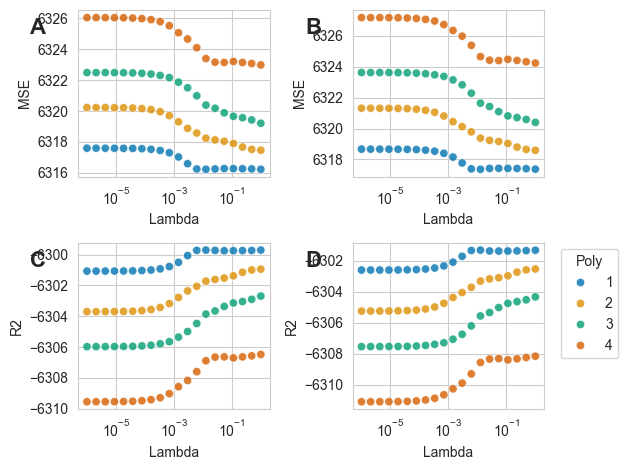

In [59]:
from utils import k_fold_cross_validation
from skimage.transform import resize
from utils import plot_mse_and_r2
OUTPUT_DIR = "output_tmp"
data = terrain1

data_orig = data.copy()

# Downsample the data
data = resize(data, (int(data.shape[0]/12), int(data.shape[1]/12)), anti_aliasing=True)

# Perform a gaussian smoothing of the data
#print(data.shape)

x = np.arange(0, data.shape[0])
y = np.arange(0, data.shape[1])

x, y = np.meshgrid(x, y)

data_flat = data.ravel()
x = x.ravel()
y = y.ravel()

index_vals = np.array(range(np.prod(data.shape)))
idx_train, idx_test = train_test_split(
        index_vals, test_size=0.3, random_state=42)

def k_fold_validation(x, y, z, k=5, polynom=25):
    """
    k-fold cross validation

    Implementation so unclever that I cant
    have lifted it from somewhere.

    """
    
    idx = np.arange(len(x))
    np.random.shuffle(idx)  # Shuffle the indices

    # Perform k-fold cross validation
    # with multuple approaches for the same set
    # of folds
    
    type_vec = ["OLS", "ridge", "lasso"]
    p_vec = np.arange(1, polynom)
    
    result_frame = pd.DataFrame(columns=["MSE_train", "MSE_test", "R2_train",
                                         "R2_test", "Polynomial", "Lambda", "Type", "Folds"])

    for type in type_vec:
        
        if type == "OLS":
            lambda_vals = [0]
        elif type == "ridge":
            lambda_vals = np.logspace(-6, 0, 20)
        elif type == "lasso":
            lambda_vals = np.logspace(-6, 0, 20)
            p_vec = np.arange(1, 5)
        for p in p_vec:
            
            print(p)
            for lambda_ in lambda_vals:

                foo = k_fold_cross_validation(idx=idx,
                                                            x=x,
                                                            y=y,
                                                            z=z,
                                                            k=k,
                                                            type=type,
                                                            lmb=lambda_,
                                                            p=p)

                result_frame = result_frame._append(foo, ignore_index=True)

    print(result_frame)
    # Plot the results

    # First the OLS

    result_frame_ols = result_frame[result_frame["Type"] == "OLS"]

    plot_mse_and_r2(result_frame_ols,
                                  OUTPUT_DIR,
                                  "terrain_OLS_mse_r2_" + str(k) + "fold.pdf",
                                  "OLS")

    # Then the ridge

    result_frame_ridge = result_frame[result_frame["Type"] == "ridge"]

    plot_mse_and_r2(result_frame_ridge,
                                  OUTPUT_DIR,
                                  "terrain_ridge_mse_r2_" + str(k) + "fold.pdf",
                                  "Ridge")

    # Then the lasso

    result_frame_lasso = result_frame[result_frame["Type"] == "lasso"]

    plot_mse_and_r2(result_frame_lasso,
                                  OUTPUT_DIR,
                                  "terrain_lasso_mse_r2_" + str(k) + "fold.pdf",
                                  "Lasso")



k_fold_validation(x_train, y_train, values_train, k=5, polynom=25)

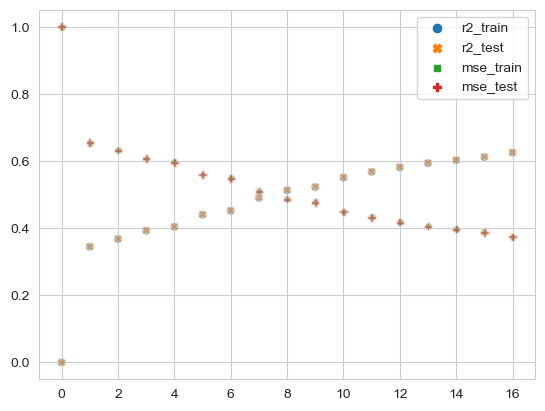

In [10]:
import seaborn as sns
sns.scatterplot(scores, alpha=0.5)
plt.show()

There is no discernable difference between train and test scores.
As the test set contains random pixels form the image, and are surrounded by pixels of very similar values, this task may have been to easy to inferr the correct values.
Instead of choosing test pixels at random, the image is now divided into two chunks for train / testing:

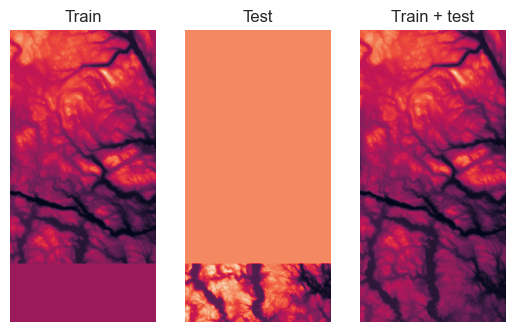

In [11]:
idx_train = index_vals[:int(len(index_vals) * 0.80)]
idx_test = index_vals[max(idx_train)+1:]

scaler = StandardScaler()
values_train = scaler.fit_transform(terrain1_values[idx_train].reshape(-1, 1))
values_test = scaler.transform(terrain1_values[idx_test].reshape(-1, 1))


x_train = idx_train.reshape(-1, 1) % terrain1.shape[0]
y_train = idx_train.reshape(-1, 1) // terrain1.shape[0]
x_test = idx_test.reshape(-1, 1) % terrain1.shape[0]
y_test = idx_test.reshape(-1, 1) // terrain1.shape[0]


scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler_x.fit_transform(x_train).reshape(-1)
x_test = scaler_x.transform(x_test).reshape(-1)
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)


img_train = np.empty(shape=len(index_vals))
img_test = np.empty(shape=len(index_vals))

img_train[idx_train] = values_train.ravel()
img_test[idx_test] = values_test.ravel()

img_train = img_train.reshape(terrain1.shape)
img_test = img_test.reshape(terrain1.shape)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(img_train)
ax[0].set_title("Train")
ax[1].imshow(img_test)
ax[1].set_title("Test")
ax[2].imshow(img_train + img_test)
ax[2].set_title("Train + test")
[axi.axis("off") for axi in ax]

plt.show()

In [17]:
scores = pd.DataFrame(dtype=float)
pvalues = list(range(1, 10))
for p in pvalues:
    # Big X = design matrix
#    X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
#    X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    X_train = generate_design_matrix(x_train, y_train, n=p)
    X_test = generate_design_matrix(x_test, y_test, n=p)
    
    betas = beta_ols_estimation(X_train, values_train)
    zhat_train = X_train @ betas
    zhat_test = X_test @ betas
    
    r2_train, r2_test = r2_score(values_train, zhat_train), r2_score(values_test, zhat_test)
    mse_train, mse_test = mean_squared_error(values_train, zhat_train), mean_squared_error(values_test, zhat_test)

    print(f"p={p}\t r2 train / test = {r2_train:.3e} / {r2_test:.3e}\t mse = {mse_train:.3e} / {mse_test:.3e}")
    scores.loc[p, ["r2_train", "r2_test", "mse_train", "mse_test"]] = [r2_train, r2_test, mse_train, mse_test]


p=1	 r2 train / test = 3.404e-01 / -6.844e-01	 mse = 6.596e-01 / 7.214e-01
p=2	 r2 train / test = 3.432e-01 / -4.037e-01	 mse = 6.568e-01 / 6.012e-01
p=3	 r2 train / test = 3.823e-01 / -3.484e+00	 mse = 6.177e-01 / 1.920e+00
p=4	 r2 train / test = 3.960e-01 / -1.745e+01	 mse = 6.040e-01 / 7.902e+00
p=5	 r2 train / test = 4.397e-01 / -2.993e+01	 mse = 5.603e-01 / 1.325e+01
p=6	 r2 train / test = 4.572e-01 / -1.815e+01	 mse = 5.428e-01 / 8.202e+00
p=7	 r2 train / test = 5.094e-01 / -2.784e+03	 mse = 4.906e-01 / 1.193e+03
p=8	 r2 train / test = 5.285e-01 / -1.257e+04	 mse = 4.715e-01 / 5.382e+03
p=9	 r2 train / test = 5.528e-01 / -3.206e+04	 mse = 4.472e-01 / 1.373e+04


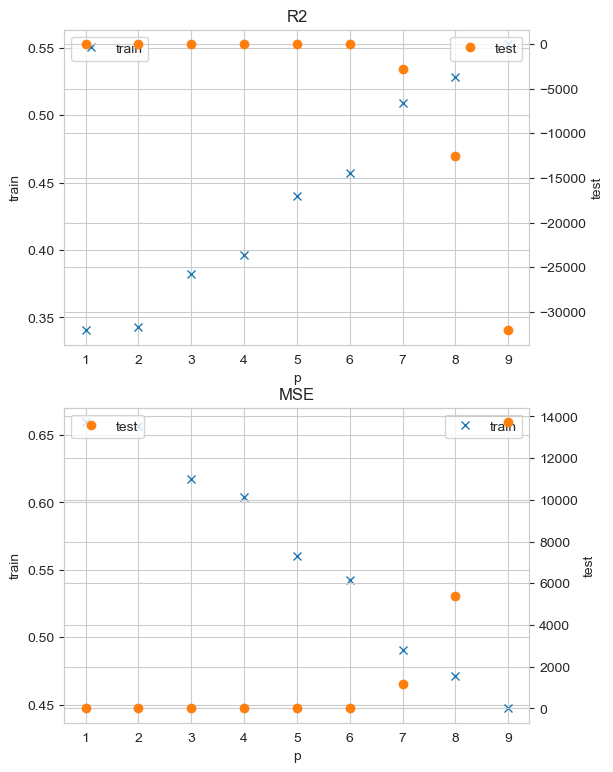

In [18]:
# import seaborn as sns

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 9))

ax1.set_title("R2")
ax1.plot(pvalues, scores["r2_train"], "x", label="train")
ax11 = ax1.twinx()
ax11.plot(pvalues, scores["r2_test"], "o", label="test", c="C1")

ax2.set_title("MSE")
ax2.plot(pvalues, scores["mse_train"], "x", label="train")
ax21 = ax2.twinx()
ax21.plot(pvalues, scores["mse_test"], "o", label="test", c="C1")


ax1.set_ylabel("train")
ax2.set_ylabel("train")
ax11.set_ylabel("test")
ax21.set_ylabel("test")
[ax.legend() for ax in [ax1, ax11, ax2, ax21]]
[ax.set_xlabel("p") for ax in [ax1, ax2]]
#ax1.set_yscale("log")
#ax2.set_yscale("log")
#ax21.set_yscale("log")

#sns.scatterplot(scores[["r2_train", "r2_test"]], alpha=0.5)
#plt.yscale("log")
plt.show()

We now see a clear trend of increased overfitting to the training data by increasing $p$, causing the test metrics to blow up in positive / negative direction for MSE / R2 respectively.

## Adding Ridge and Lasso penalization

In [19]:
from sklearn.linear_model import Ridge, Lasso
del scores

#pvals = list(range(1, 5))
pvals = [2, 4, 6]
avals = np.logspace(-7, 2, 9)

# mse_train_vals = np.ones((len(pvals), len(avals))
mse_test_vals_1 = np.ones(shape=(len(pvals), len(avals)))
mse_test_vals_2 = np.ones(shape=(len(pvals), len(avals)))


for i, p in enumerate(pvals):
    # X_train = create_2d_polynomial_design_matrix(x_train, y_train, pmax=p)
    # X_test = create_2d_polynomial_design_matrix(x_test, y_test, pmax=p)
    X_train = generate_design_matrix(x_train, y_train, n=p)
    X_test = generate_design_matrix(x_test, y_test, n=p)
    
    
    for j, a in enumerate(avals):
        print(f"{p} {a:.2e}", end="\t")
        m1 = Ridge(alpha=a, fit_intercept=False)
        m2 = Lasso(alpha=a, fit_intercept=False)
        m1.fit(X_train, values_train)
        m2.fit(X_train, values_train)

        zhat_test_1 = m1.predict(X_test)
        zhat_test_2 = m2.predict(X_test)

        mse_test_1, mse_test_2 = mean_squared_error(values_test, zhat_test_1), mean_squared_error(values_test, zhat_test_2)
        print(mse_test_1, mse_test_2)
        
        mse_test_vals_1[i, j] = mse_test_1
        mse_test_vals_2[i, j] = mse_test_2


2 1.00e-07	0.6012064962875754 0.6012066437688559
2 1.33e-06	0.6012064962871713 0.6012087646148935
2 1.78e-05	0.6012064962817766 0.6012615769371502
2 2.37e-04	0.60120649620984 0.6027751506182248
2 3.16e-03	0.601206495250553 0.6267116517833246
2 4.22e-02	0.6012064824582561 0.5718957777584247
2 5.62e-01	0.601206311870217 0.9811328213948302
2 7.50e+00	0.6012040370381505 0.9811328213948302
2 1.00e+02	0.6011737009555086 0.9811328213948302
4 1.00e-07	7.902014248230818 7.901667179254274
4 1.33e-06	7.902014247516169 7.897329235039569
4 1.78e-05	7.902014237986048 7.839717267565044
4 2.37e-04	7.902014110899891 7.1094446692102835
4 3.16e-03	7.902012416179434 1.8151972331817297
4 4.22e-02	7.901989816782817 0.5718957777584247
4 5.62e-01	7.901688460340483 0.9811328213948302
4 7.50e+00	7.8976718258515906 0.9811328213948302
4 1.00e+02	7.844465637417978 0.9811328213948302
6 1.00e-07	

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e+06, tolerance: 5.188e+02
  model = cd_fast.enet_coordinate_descent(


8.20248404568197 10.365521799558827
6 1.33e-06	

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e+06, tolerance: 5.188e+02
  model = cd_fast.enet_coordinate_descent(


8.202483992550656 10.245962784970311
6 1.78e-05	

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+06, tolerance: 5.188e+02
  model = cd_fast.enet_coordinate_descent(


8.202483283992038 8.766367595062693
6 2.37e-04	

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.154e+04, tolerance: 5.188e+02
  model = cd_fast.enet_coordinate_descent(


8.202473835200614 6.792369255119611
6 3.16e-03	8.202347835160447 11.718986591606182
6 4.22e-02	8.200667876081274 0.5718957777584247
6 5.62e-01	8.178314718131531 0.9811328213948302
6 7.50e+00	7.888857015981886 0.9811328213948302
6 1.00e+02	5.23794165531995 0.9811328213948302


(3, 9)
(5188320, 28) (1297081, 28)
[1.00000000e-07 1.33352143e-06 1.77827941e-05 2.37137371e-04
 3.16227766e-03 4.21696503e-02 5.62341325e-01 7.49894209e+00
 1.00000000e+02]
[2, 4, 6]


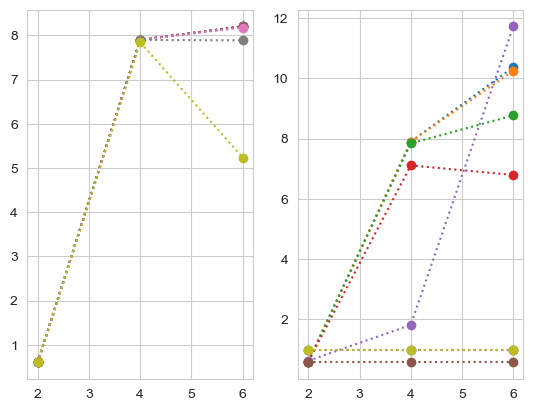

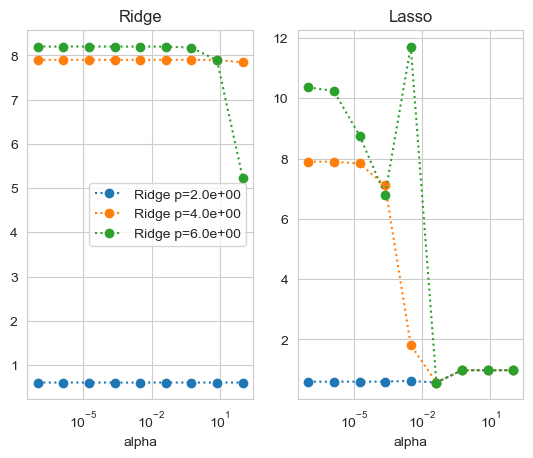

In [32]:
print(mse_test_vals_1.shape)
print(X_train.shape, X_test.shape)
print(avals)
print(pvals)
#plt.figure()
fig, ax = plt.subplots(ncols=2)
for j in range(mse_test_vals_1.shape[1]):
    a = avals[j]
    ax[0].plot(pvals, mse_test_vals_1[:, j], "o:", label=f"ridge $\alpha$={a:.1f}")
    ax[1].plot(pvals, mse_test_vals_2[:, j], "o:", label=f"lasso $\alpha$={a:.1f}")


fig, ax = plt.subplots(ncols=2)
for i in range(mse_test_vals_1.shape[0]):
    p = pvals[i]
    ax[0].plot(avals, mse_test_vals_1[i, :], "o:", label=f"Ridge p={p:.1e}")
    ax[1].plot(avals, mse_test_vals_2[i, :], "o:", label=f"Lasso p={p:.1e}")

ax[0].set_title("Ridge")
ax[1].set_title("Lasso")
ax[0].legend()

for axx in ax:
    axx.set_xscale("log")
    axx.set_xlabel("alpha")

plt.show()